In [1]:
import torch
torch.set_default_dtype(torch.float64)
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from torch.nn import Parameter
from torch.optim import Adam
from gpytorch.optim import NGD

from lafomo.datasets import LFMDataset
from lafomo.models import OrdinaryLFM, MultiOutputGP #MLPLFM
from lafomo.utilities.torch import inv_softplus, softplus
from lafomo.datasets import DeterministicLotkaVolterra
from lafomo.plot import Plotter
from lafomo.configuration import VariationalConfiguration
from lafomo.trainers import VariationalTrainer

import numpy as np

f64 = np.float64

Lotka-Voltera is in greek mode.
Creating dataset...
greek


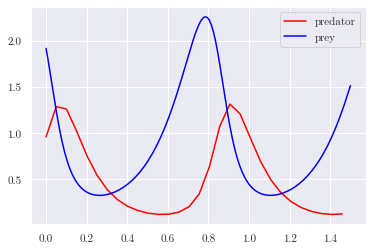

In [2]:
dataset = DeterministicLotkaVolterra(alpha = 2./3,
							beta = 4./3, gamma = 1., delta = 1.)
x_min, x_max = 0.0, 1.5
initial_x = -0.1

plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='predator')
plt.plot(np.linspace(x_min, x_max, dataset.prey.shape[0]), dataset.prey, c='blue', label='prey')
plt.legend()
num_latents = 1
num_outputs = 1

t_observed = dataset.data[0][0].view(-1)
output_names = np.array(['pred','prey'])

In [5]:
from gpytorch.constraints import Positive
class LotkaVolterra(OrdinaryLFM):
    """Outputs are predator. Latents are prey"""
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration):
        super().__init__(num_outputs, gp_model, config, num_training_points=100)
        self.raw_decay = Parameter(torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_growth = Parameter(torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_initial = Parameter(0.3+torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.positivity = Positive()

    @property
    def decay_rate(self):
        return self.positivity.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.positivity.inverse_transform(value)

    @property
    def growth_rate(self):
        return self.positivity.transform(self.raw_growth)

    @growth_rate.setter
    def growth_rate(self, value):
        self.raw_growth = self.positivity.inverse_transform(value)

    @property
    def initial_predators(self):
        return self.positivity.transform(self.raw_initial)

    @initial_predators.setter
    def initial_predators(self, value):
        self.raw_initial = self.positivity.inverse_transform(value)

    def initial_state(self):
        return self.initial_predators

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        # print(t, self.t_index, self.f.shape)

        f = self.f[:, :, self.t_index].unsqueeze(2)
        # print(self.growth_rate.shape, f.shape, h.shape)
        h = self.growth_rate * f * h - self.decay_rate * h
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        #softplus
        return softplus(f).repeat(1, self.num_outputs, 1)

In [6]:
use_natural = False
config = VariationalConfiguration(
    num_samples=70,
    kernel_scale=False,
    initial_conditions=False # TODO
)

num_inducing = 30  # (I x m x 1)
inducing_points = torch.linspace(x_min, x_max, num_inducing).repeat(num_latents, 1).view(num_latents, num_inducing, 1)
t_predict = torch.linspace(-.3, 1.8, 120, dtype=torch.float32)

gp_model = MultiOutputGP(inducing_points, num_latents,
                         use_ard=False,
                         initial_lengthscale=0.2,
                         use_scale=True,
                         natural=use_natural)

lfm = LotkaVolterra(num_outputs, gp_model, config)
plotter = Plotter(lfm, np.array(['predator']))

In [7]:
track_parameters = [
    'raw_initial',
    'raw_growth',
    'raw_decay',
    'gp_model.covar_module.base_kernel.raw_lengthscale',
]
num_training = dataset[0][0].shape[0]
print(num_training)
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.05)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.05)]

trainer = VariationalTrainer(lfm, optimizers, dataset, track_parameters=track_parameters)

30


### Outputs prior to training:

In [9]:
gp = lfm.predict_m(t_predict)

plotter.plot_gp(gp, t_predict)
plotter.plot_latents(t_predict,
                     transform=softplus,
                     t_scatter=t_observed)

NameError: name 'self' is not defined

In [10]:
lfm.train()

output = trainer.train(100, report_interval=2, step_size=1e-2)

Epoch 001/200 - Loss: 1.33 (1.33 0.00) kernel: [[[0.19112009]]]
Epoch 003/200 - Loss: 1.15 (1.14 0.01) kernel: [[[0.1794328]]]
Epoch 005/200 - Loss: 1.10 (1.07 0.03) kernel: [[[0.17297636]]]
Epoch 007/200 - Loss: 1.05 (1.02 0.03) kernel: [[[0.16866253]]]
Epoch 009/200 - Loss: 1.00 (0.97 0.03) kernel: [[[0.16552593]]]
Epoch 011/200 - Loss: 0.95 (0.92 0.03) kernel: [[[0.16294013]]]
Epoch 013/200 - Loss: 0.91 (0.88 0.02) kernel: [[[0.16055972]]]
Epoch 015/200 - Loss: 0.86 (0.84 0.02) kernel: [[[0.15824379]]]
Epoch 017/200 - Loss: 0.82 (0.80 0.02) kernel: [[[0.15590845]]]
Epoch 019/200 - Loss: 0.77 (0.76 0.02) kernel: [[[0.15346881]]]
Epoch 021/200 - Loss: 0.73 (0.71 0.01) kernel: [[[0.15087686]]]
Epoch 023/200 - Loss: 0.68 (0.67 0.01) kernel: [[[0.14803157]]]
Epoch 025/200 - Loss: 0.64 (0.63 0.01) kernel: [[[0.14494098]]]
Epoch 027/200 - Loss: 0.59 (0.58 0.01) kernel: [[[0.14151204]]]
Epoch 029/200 - Loss: 0.54 (0.54 0.01) kernel: [[[0.13787645]]]
Epoch 031/200 - Loss: 0.50 (0.49 0.01) ke

### Outputs after training

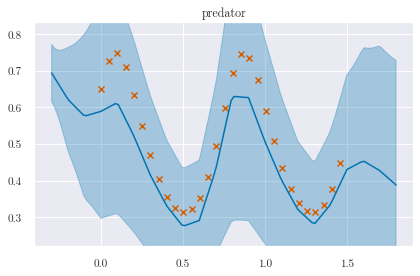

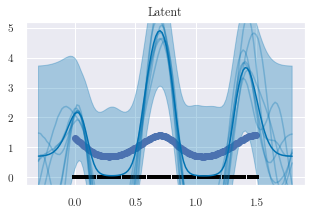

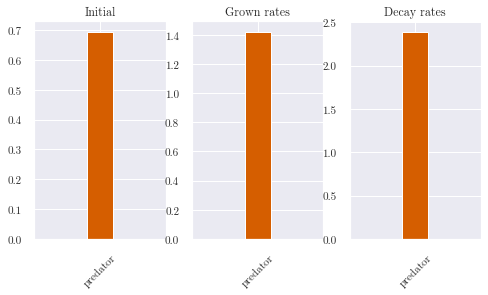

In [15]:
t_predict = torch.linspace(-.3, 1.8, 120, dtype=torch.float32)
lfm.eval()
t_scatter = dataset.data[0][0].unsqueeze(0).unsqueeze(0)
y_scatter = dataset.data[0][1].unsqueeze(0).unsqueeze(0)
plotter.plot_outputs(t_predict, t_scatter=t_scatter, y_scatter=y_scatter)
plotter.plot_latents(t_predict, transform=softplus)
plt.scatter(np.linspace(0, 1.5, 150), dataset.prey)
labels = ['Initial', 'Grown rates', 'Decay rates']
kinetics = list()
for key in ['raw_initial', 'raw_growth', 'raw_decay']:
    kinetics.append(softplus(trainer.parameter_trace[key][-1]).squeeze().numpy())

plotter.plot_double_bar(kinetics, labels)

tensor([1.2995, 1.2720, 1.2420, 1.2100, 1.1765, 1.1420, 1.1070, 1.0719, 1.0371,
        1.0031, 0.9702, 0.9386, 0.9087, 0.8805, 0.8541, 0.8298, 0.8074, 0.7871,
        0.7688, 0.7524, 0.7381, 0.7256, 0.7150, 0.7062, 0.6991, 0.6936, 0.6898,
        0.6875, 0.6868, 0.6875, 0.6895, 0.6930, 0.6978, 0.7039, 0.7113, 0.7199,
        0.7298, 0.7408, 0.7530, 0.7664, 0.7809, 0.7965, 0.8132, 0.8310, 0.8498,
        0.8697, 0.8905, 0.9122, 0.9348, 0.9583, 0.9825, 1.0074, 1.0329, 1.0589,
        1.0852, 1.1119, 1.1386, 1.1652, 1.1916, 1.2176, 1.2428, 1.2671, 1.2902,
        1.3119, 1.3317, 1.3494, 1.3648, 1.3774, 1.3871, 1.3935, 1.3963, 1.3955,
        1.3909, 1.3824, 1.3700, 1.3537, 1.3339, 1.3107, 1.2844, 1.2554, 1.2243,
        1.1914, 1.1573, 1.1224, 1.0873, 1.0523, 1.0179, 0.9845, 0.9523, 0.9216,
        0.8926, 0.8654, 0.8402, 0.8170, 0.7957, 0.7765, 0.7594, 0.7441, 0.7309,
        0.7194, 0.7098, 0.7020, 0.6958, 0.6913, 0.6883, 0.6869, 0.6870, 0.6885,
        0.6913, 0.6955, 0.7011, 0.7079, 

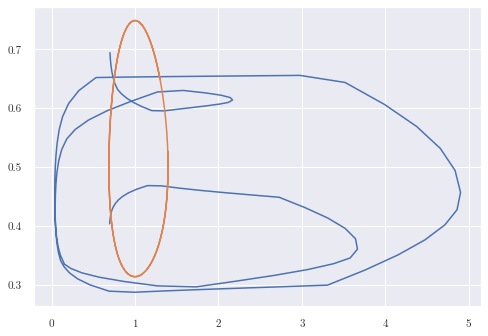

In [13]:
# Phase space
prey = lfm.likelihood(lfm.gp_model(t_predict)).mean.detach().squeeze()
predator = lfm(t_predict).mean.detach().squeeze()
plt.plot(softplus(prey), (predator), label='Predicted')
print(dataset.prey)
plt.plot(dataset.prey, dataset.predator, label='Target')

In [53]:
print(lfm.growth_rate)

tensor([[1.7732]], grad_fn=<SoftplusBackward>)


In [11]:
print(kinetics)

[array(0.61244234), array(0.83345752), array(1.13855773)]


In [12]:

titles = ['basal', 'decay', 'sensitivity', 'lengthscale']
datas = [np.array(trainer.basalrates)[:,:,0],
         np.array(trainer.decayrates)[:,:,0],
         np.array(trainer.sensitivities)[:,:,0],
         np.array(trainer.lengthscales)]

plt.figure(figsize=(5, 6))
for i, (title, data) in enumerate(zip(titles, datas)):
    plt.subplot(411 + i)
    plt.title(title)
    # if data.ndim > 1:
    #     for j in range(data.shape[1]):

    plt.plot(data)

AttributeError: 'VariationalTrainer' object has no attribute 'basalrates'

In [ ]:

var_params = dict(gp_model.variational_strategy.named_variational_parameters())
mean = var_params['base_variational_strategy._variational_distribution.variational_mean']
plt.scatter(np.linspace(0, 1.5, num_inducing), mean.squeeze().detach())
plt.scatter(inducing_points.squeeze(), np.zeros(num_inducing), marker='_')